# Bot de inversion para cripto

In [1]:
#!pip install yfinance
#!pip install mpl_finance
#!pip install python-binance
#!pip3 install plotly

## import dependencies

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from datetime import date
from datetime import timedelta
import plotly.graph_objects as go
from binance import Client
from config import API_Key,Secret_Key
import os

## Gathering data with binance api

In [3]:
client = Client(API_Key, Secret_Key)

In [4]:
# get historical kline data from any date range
#BTCOIN USDOLAR PRICE
#first currency and crypto,then time interval, and time to go back
# arguments of function have to be strings


def get_crypto_data(crypto, interval, lookback):
    Crypto_df = pd.DataFrame(client.get_historical_klines(crypto, interval, lookback + ' ago UTC'))
    
   # show only first 5 columns
    Crypto_df = Crypto_df.iloc[:,:6]
    #naming columns
    Crypto_df.columns = ['Date_and_Time','Open', 'High', 'Low','Last','Volume']
    # from the complete data, set index to date
#     Crypto_df = Crypto_df.\
#     set_index(pd.DatetimeIndex(Crypto_df['Date'].values))
#     Crypto_df.tail()
    Crypto_df = Crypto_df.set_index('Date_and_Time')
    Crypto_df.index = pd.to_datetime(Crypto_df.index, unit='ms')
#     Crypto_df.tz_localize('UTC').tz_convert('Mexico/General')
    

   # all values are stored as string so change them into float.
    Crypto_df = Crypto_df.astype(float)
    return Crypto_df

## Creating historical data : crypto df

In [5]:
lookback = '6 months'
crypto_df= get_crypto_data('BTCUSDT', '30m', lookback).tz_localize('UTC').tz_convert('Mexico/General')
crypto_df.shape

(8819, 5)

In [6]:
crypto_df.tail(10)

,Open,High,Low,Last,Volume
Date_and_Time,,,,,
2021-11-23 16:30:00-06:00,57646.58,57676.30,57411.36,57561.23,422.00327
2021-11-23 17:00:00-06:00,57561.23,57638.06,57445.14,57582.67,476.29854
2021-11-23 17:30:00-06:00,57582.68,57735.00,57524.99,57541.27,379.71184
2021-11-23 18:00:00-06:00,57541.26,57674.64,57438.63,57583.61,715.68621
2021-11-23 18:30:00-06:00,57583.62,57735.00,57482.90,57493.89,440.67955
2021-11-23 19:00:00-06:00,57493.90,57559.01,57089.60,57167.49,1284.17338
2021-11-23 19:30:00-06:00,57167.49,57398.16,57000.19,57038.74,536.22947
2021-11-23 20:00:00-06:00,57040.17,57121.20,56388.00,56423.64,1086.23815
2021-11-23 20:30:00-06:00,56423.65,56555.20,56136.00,56258.79,1098.99958


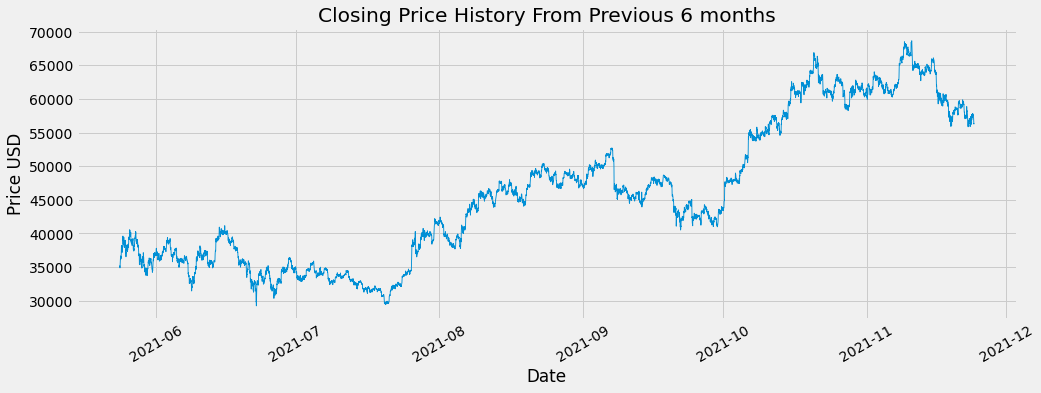

In [7]:
# plot prices
plt.figure(figsize=(15, 5))
plt.plot(crypto_df['Last'],label='closing price', linewidth = 0.9)
plt.title(f'Closing Price History From Previous {lookback}')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.xticks(rotation=30)
plt.show()

## historical price w plotly to html

In [8]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')
fig = go.Figure(data=[go.Candlestick(x=crypto_df.index,
                open=crypto_df['Open'],
                high=crypto_df['High'],
                low=crypto_df['Low'],
                close=crypto_df['Last'])])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.write_html(f'{path}/historical.html')

# code machine larning: Linear regresion and tecnical indicators and forward testing

In [9]:
# showing only BTC price
crypto_last_price_df = crypto_df[['Last']]
crypto_last_price_df.head(16)

,Last
Date_and_Time,
2021-05-23 22:30:00-05:00,35251.37
2021-05-23 23:00:00-05:00,35050.87
2021-05-23 23:30:00-05:00,34881.09
2021-05-24 00:00:00-05:00,35143.45
2021-05-24 00:30:00-05:00,35292.60
2021-05-24 01:00:00-05:00,35420.79
2021-05-24 01:30:00-05:00,36089.71
2021-05-24 02:00:00-05:00,36198.61
2021-05-24 02:30:00-05:00,36645.79


In [10]:
#  variable for predicting x number of periods into the future
predict_periods = 16 #numer of periods, then change this info to function

# create another column shifted n units up
crypto_last_price_df['Prediction'] = crypto_last_price_df[['Last']].shift(-predict_periods)

<ipython-input-10-91f82b2f9c00>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# show df with new column
crypto_last_price_df.head(16)

,Last,Prediction
Date_and_Time,,
2021-05-23 22:30:00-05:00,35251.37,37600.01
2021-05-23 23:00:00-05:00,35050.87,38105.79
2021-05-23 23:30:00-05:00,34881.09,38211.21
2021-05-24 00:00:00-05:00,35143.45,37850.00
2021-05-24 00:30:00-05:00,35292.60,37571.60
2021-05-24 01:00:00-05:00,35420.79,37550.27
2021-05-24 01:30:00-05:00,36089.71,37680.98
2021-05-24 02:00:00-05:00,36198.61,37921.99
2021-05-24 02:30:00-05:00,36645.79,37539.63


In [12]:
# show last 15 rows of new dataset
crypto_last_price_df.tail(17)

,Last,Prediction
Date_and_Time,,
2021-11-23 13:00:00-06:00,57456.94,56377.42
2021-11-23 13:30:00-06:00,57778.20,NaN
2021-11-23 14:00:00-06:00,57503.89,NaN
2021-11-23 14:30:00-06:00,57831.77,NaN
2021-11-23 15:00:00-06:00,57650.00,NaN
2021-11-23 15:30:00-06:00,57676.06,NaN
2021-11-23 16:00:00-06:00,57646.59,NaN
2021-11-23 16:30:00-06:00,57561.23,NaN
2021-11-23 17:00:00-06:00,57582.67,NaN


In [13]:
# create independent dataset, convert the dataframe to a np array and drop prediction column
a=np.array(crypto_last_price_df[['Last']])
#remove the last n rows where n is the prediction days
a=a[:-predict_periods]
print(a)

[[35251.37]
 [35050.87]
 [34881.09]
 ...
 [57181.79]
 [57421.01]
 [57456.94]]


In [14]:
# CREATE THE DEPENDENT DATA SET
#CONVERT THE DF TO A NP ARRAY
b = crypto_last_price_df['Prediction'].values

#get all values except las n rows
b = b[:-predict_periods]
print(b)

[37600.01 38105.79 38211.21 ... 56423.64 56258.79 56377.42]


In [15]:
# split the data into 85% traning and 15% testing
a_train, a_test, b_train, b_test = train_test_split(a,b, test_size = 0.15, shuffle = False)

In [16]:
# create and train the model
Lreg = LinearRegression()
# train
Lreg.fit(a_train,b_train)


LinearRegression()

## linear regression similarity

In [17]:
# test shows R^2 
Lreg_similarity = Lreg.score(a_test,b_test)
print('LIN REG SIMILARITY:', Lreg_similarity)

LIN REG SIMILARITY: 0.8702630900170207


In [18]:
# create variable a_projection and set equal to last 14 rows of original dataset
a_projection = np.array(crypto_last_price_df[['Last']])[-predict_periods:]
print(a_projection)

[[57778.2 ]
 [57503.89]
 [57831.77]
 [57650.  ]
 [57676.06]
 [57646.59]
 [57561.23]
 [57582.67]
 [57541.27]
 [57583.61]
 [57493.89]
 [57167.49]
 [57038.74]
 [56423.64]
 [56258.79]
 [56377.42]]


In [19]:
# print lreg models predictions for next 14 days
Lreg_predict = Lreg.predict(a_projection)
print(Lreg_predict)

[57784.45231486 57510.94452145 57837.86565194 57656.62722968
 57682.61101845 57653.22720207 57568.11683334 57589.49413308
 57548.21520541 57590.43138409 57500.97376598 57175.5283073
 57047.15483057 56433.85366136 56269.48575737 56387.76882956]


## price results with machine learning prediction

In [20]:
results_compare=zip(a_projection,Lreg_predict)
results_df= pd.DataFrame(results_compare, columns = ['actual_price', 'predicted_price'])

previously_predicted = results_df[['predicted_price']]

# date = datetime.now().strftime("%Y_%m_%d_%I_%M_%S_%p")
# previously_predicted.to_csv(f'Resources/previous_predicted_price_{date}.csv') 

pwd = os.getcwd()
path = os.path.join(pwd,'Resources')
entries = os.listdir(path)

price_results_df = pd.concat([results_df, pd.read_csv('Resources/'+ entries[-2])], axis =1)
price_results_df.drop(columns=['Unnamed: 0'],inplace=True, axis=1)
price_results_df.columns = ['actual_price', 'predicted_price', 
                                            'previously_predicted_price']
price_results_df = price_results_df.astype(float)
price_results_df.head(17)

,actual_price,predicted_price,previously_predicted_price
0,57778.20,57784.452315,57200.506306
1,57503.89,57510.944521,57259.945892
2,57831.77,57837.865652,58893.570304
3,57650.00,57656.627230,58251.744680
4,57676.06,57682.611018,58284.576833
5,57646.59,57653.227202,58202.126764
6,57561.23,57568.116833,58234.998883
7,57582.67,57589.494133,57917.977770
8,57541.27,57548.215205,57757.174159
9,57583.61,57590.431384,57538.060004


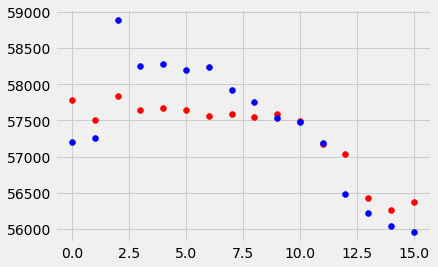

In [21]:
plt.scatter(price_results_df.index,price_results_df.actual_price, color='r', label='actual')
plt.scatter(price_results_df.index, price_results_df.previously_predicted_price, color='b', label='previous')
plt.show()

In [73]:
# for i in range(len(price_results_df)):
#     print(price_results_df.actual_price[i])
correlation = []
for i in range(len(price_results_df)):
    x=(abs(price_results_df.actual_price[i]-\
       price_results_df.previously_predicted_price[i]))/price_results_df.actual_price[i]
    correlation.append(x*100)

In [74]:
similarity_price = pd.DataFrame(correlation)
similarity_price.columns = ['Similarity_percentage']
similarity_price

,Similarity_percentage
0,0.999847
1,0.424222
2,1.836016
3,1.043790
4,1.055060
5,0.963694
6,1.170526
7,0.582307
8,0.375216
9,0.079102


In [24]:
price_results_df.corr()

,actual_price,predicted_price,previously_predicted_price
actual_price,1.000000,1.000000,0.888044
predicted_price,1.000000,1.000000,0.888044
previously_predicted_price,0.888044,0.888044,1.000000


In [25]:
results_df.describe()

,predicted_price
count,16.000000
mean,57327.296915
std,517.733302
min,56269.485757
25%,57143.434938
50%,57558.166019
75%,57654.077209
max,57837.865652


In [26]:
price_results_df.actual_price.describe()

count       16.000000
mean     57319.703750
std        519.251829
min      56258.790000
25%      57135.302500
50%      57551.250000
75%      57647.442500
max      57831.770000
Name: actual_price, dtype: float64

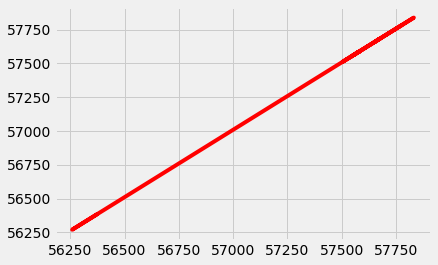

In [27]:
plt.plot(a_projection,Lreg_predict, color='r')

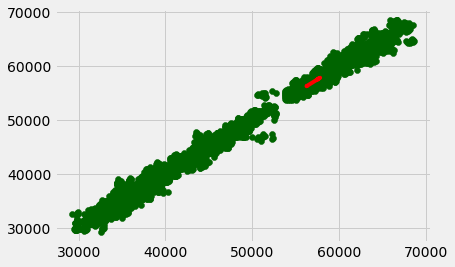

In [28]:
plt.scatter(a, b, color="DarkGreen" )
plt.plot(a_projection,Lreg_predict, color='r')
plt.show()

## TI MACHINE L GRAPAHS

In [29]:
def TI_MachLearn_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.predicted_price.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.predicted_price.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k')
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r')
    plt.title('MACD graph next 16 periods')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')

   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 2 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['predicted_price'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['predicted_price'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['predicted_price','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['predicted_price'], color = 'k', label='closing price')
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA')
    ax.set_title('BBands next 16 periods')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()    

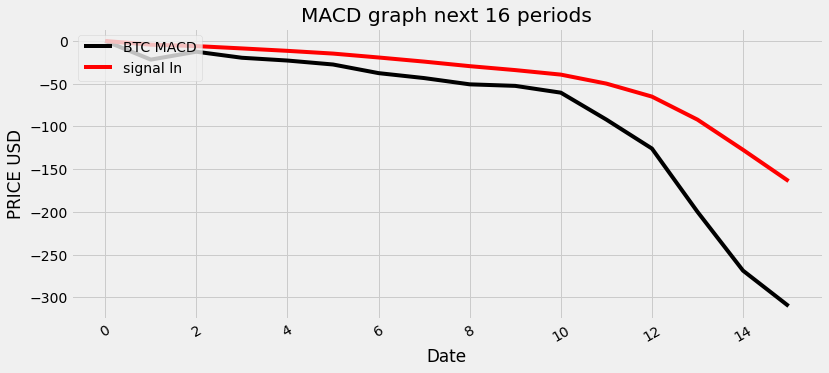

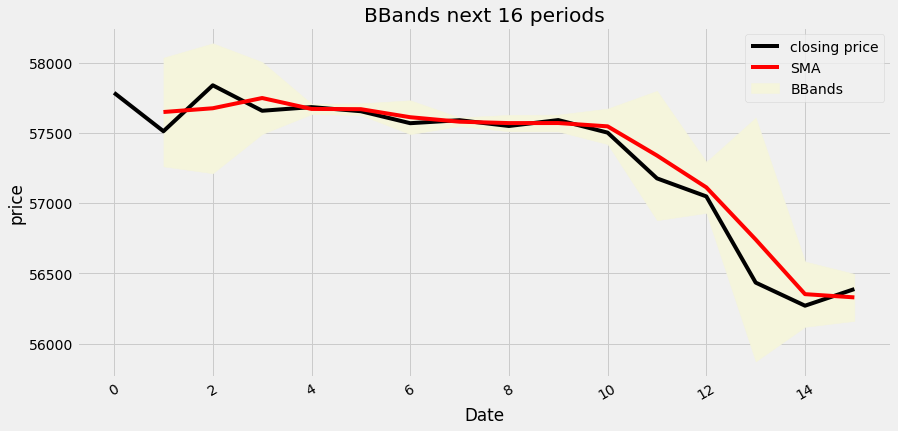

In [30]:
TI_MachLearn_graphs(results_df)

## macd machine learning notification

In [31]:
#buy sell signal
def alert_MACD_ML(signal):
    buy = []
    
    
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            
            if flag != 1:
                buy.append('1')
                
                flag = 1
            else:
                buy.append(np.nan)
                
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)

            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
                
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            
    return(buy, sell)
            

In [32]:
#Create DF for MACD
crypto_MACD_ML_df= results_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['S_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_ML_df['L_EMA']=crypto_MACD_ML_df.predicted_price.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_ML_df['MACD_line']=\
                          crypto_MACD_ML_df.S_EMA-crypto_MACD_ML_df.L_EMA
#calculate Signal Line
crypto_MACD_ML_df['Sig_line']=\
                          crypto_MACD_ML_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_ML_df.tail(20)

,actual_price,predicted_price,S_EMA,L_EMA,MACD_line,Sig_line
0,[57778.2],57784.452315,57784.452315,57784.452315,0.000000,0.000000
1,[57503.89],57510.944521,57742.374193,57764.192478,-21.818286,-4.363657
2,[57831.77],57837.865652,57757.065187,57769.649750,-12.584564,-6.007838
3,[57650.0],57656.627230,57741.613193,57761.277712,-19.664519,-8.739175
4,[57676.06],57682.611018,57732.535936,57755.450549,-22.914614,-11.574262
5,[57646.59],57653.227202,57720.334592,57747.878450,-27.543858,-14.768181
6,[57561.23],57568.116833,57696.916475,57734.562774,-37.646299,-19.343805
7,[57582.67],57589.494133,57680.389961,57723.816949,-43.426988,-24.160442
8,[57541.27],57548.215205,57660.055383,57710.809412,-50.754029,-29.479159
9,[57583.61],57590.431384,57649.343999,57701.892521,-52.548523,-34.093032


In [55]:
#create buy and sell columns in df
x = alert_MACD_ML(crypto_MACD_ML_df)
crypto_MACD_ML_df['ML_MACD_Buy_Notification'] = x[0]
crypto_MACD_ML_df['ML_MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_ML_BuySell_Sig_df = crypto_MACD_ML_df[['ML_MACD_Buy_Notification',
                                                   'ML_MACD_Sell_Notification']]
crypto_MACD_ML_BuySell_Sig_df.fillna(0)

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification
0,0.0,0
1,0.0,1
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0
6,0.0,0
7,0.0,0
8,0.0,0
9,0.0,0


## BBand ML notification

In [34]:
crypto_ML_BBand_df = results_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 2

# calculate SMA
crypto_ML_BBand_df['SMA']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).mean()
#calculate std
crypto_ML_BBand_df['STD']=crypto_ML_BBand_df['predicted_price'].rolling(window = period).std()
#calculate BB UP
crypto_ML_BBand_df['BBand Upper']=crypto_ML_BBand_df['SMA']+(crypto_ML_BBand_df['STD']*2)
#calculate BB LOW
crypto_ML_BBand_df['BBand Lower']=crypto_ML_BBand_df['SMA']-(crypto_ML_BBand_df['STD']*2)

crypto_ML_BBand_df.head()

,actual_price,predicted_price,SMA,STD,BBand Upper,BBand Lower
0,[57778.2],57784.452315,NaN,NaN,NaN,NaN
1,[57503.89],57510.944521,57647.698418,193.399215,58034.496849,57260.899987
2,[57831.77],57837.865652,57674.405087,231.168148,58136.741383,57212.068790
3,[57650.0],57656.627230,57747.246441,128.154917,58003.556276,57490.936606
4,[57676.06],57682.611018,57669.619124,18.373313,57706.365751,57632.872498


In [35]:
#buy sell signal
def alert_ML_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['predicted_price'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['predicted_price'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [56]:
#create buy and sell columns in df
x=alert_ML_BBands(crypto_ML_BBand_df)
crypto_ML_BBand_df['ML_BB_Buy_Notification'] = x[0]
crypto_ML_BBand_df['ML_BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_ML_BBand_BuySell_Sig_df = crypto_ML_BBand_df[['ML_BB_Buy_Notification',
                                                     'ML_BB_Sell_Notification']]
crypto_ML_BBand_BuySell_Sig_df.fillna(0)

,ML_BB_Buy_Notification,ML_BB_Sell_Notification
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Techincal indicators strategy

## MACD df

In [37]:
#Create DF for MACD
crypto_MACD_df= crypto_df.copy(deep=True)
#Calculate MACD and signal line 
# short term EMA ewm=exponential weighted functions
crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
#Long term EMA ewm=exponential weighted functions
crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
#Calculate MACD line
crypto_MACD_df['MACD_line']=\
                          crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
#calculate Signal Line
crypto_MACD_df['Sig_line']=\
                          crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
crypto_MACD_df.tail(20)


,Open,High,Low,Last,Volume,S_EMA,L_EMA,MACD_line,Sig_line
Date_and_Time,,,,,,,,,
2021-11-23 11:30:00-06:00,57513.70,57725.00,57236.00,57245.04,940.63768,57103.755312,56899.123289,204.632022,117.602460
2021-11-23 12:00:00-06:00,57245.03,57372.99,57110.00,57181.79,638.47744,57115.760648,56920.061564,195.699084,133.221785
2021-11-23 12:30:00-06:00,57181.79,57580.10,57151.00,57421.01,572.87004,57162.722087,56957.168856,205.553231,147.688074
2021-11-23 13:00:00-06:00,57421.00,57593.20,57224.13,57456.94,810.37928,57207.986381,56994.188941,213.797441,160.909948
2021-11-23 13:30:00-06:00,57457.24,57854.39,57360.92,57778.20,801.40284,57295.711554,57052.263834,243.447720,177.417502
2021-11-23 14:00:00-06:00,57778.21,57835.08,57400.56,57503.89,791.35872,57327.739007,57085.717624,242.021383,190.338278
2021-11-23 14:30:00-06:00,57503.89,57850.01,57380.49,57831.77,781.82755,57405.282237,57140.980763,264.301474,205.130917
2021-11-23 15:00:00-06:00,57831.77,57849.97,57546.33,57650.00,542.64303,57442.931123,57178.685892,264.245232,216.953780
2021-11-23 15:30:00-06:00,57650.00,57717.27,57511.10,57676.06,484.48094,57478.797104,57215.528418,263.268686,226.216761


## MACD graph w Plotly to html

In [90]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['MACD_line'],
                        line=dict(color='red',width = 1.5), name = 'MACD LN'))
fig.add_trace(go.Scatter(x=crypto_MACD_df.index, y=crypto_MACD_df['Sig_line'],
                        line=dict(color='blue',width = 1.5), name = 'SIG LN'))


fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/MACD.html')

## MACD buy and sell notification

In [38]:
#buy sell signal
def alert_MACD(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['MACD_line'][i] > signal['Sig_line'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['MACD_line'][i] < signal['Sig_line'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [54]:
#create buy and sell columns in df
x = alert_MACD(crypto_MACD_df)
crypto_MACD_df['MACD_Buy_Notification'] = x[0]
crypto_MACD_df['MACD_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_MACD_BuySell_Sig_df = crypto_MACD_df[['MACD_Buy_Notification', 'MACD_Sell_Notification']][-16:]
crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,MACD_Buy_Notification,MACD_Sell_Notification
Date_and_Time,,
2021-11-23 21:00:00-06:00,0,0
2021-11-23 20:30:00-06:00,0,0
2021-11-23 20:00:00-06:00,0,0
2021-11-23 19:30:00-06:00,0,0
2021-11-23 19:00:00-06:00,0,0
2021-11-23 18:30:00-06:00,0,0
2021-11-23 18:00:00-06:00,0,0
2021-11-23 17:30:00-06:00,0,0
2021-11-23 17:00:00-06:00,0,1


## BOLLINGER BANDS df

In [40]:
crypto_BBand_df =crypto_df.copy(deep=True)
# calculate SMA, SD, UPPER BAN, LOWER BAND
#GET TIME PERIOD
period = 20

# calculate SMA
crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
#calculate std
crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
#calculate BB UP
crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
#calculate BB LOW
crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

crypto_BBand_df.head(30)

,Open,High,Low,Last,Volume,SMA,STD,BBand Upper,BBand Lower
Date_and_Time,,,,,,,,,
2021-05-23 22:30:00-05:00,35673.39,35696.86,35141.56,35251.37,1867.140180,NaN,NaN,NaN,NaN
2021-05-23 23:00:00-05:00,35250.56,35423.36,34942.91,35050.87,1725.136529,NaN,NaN,NaN,NaN
2021-05-23 23:30:00-05:00,35050.87,35200.00,34031.00,34881.09,3905.041541,NaN,NaN,NaN,NaN
2021-05-24 00:00:00-05:00,34886.16,35489.88,34881.71,35143.45,2039.351534,NaN,NaN,NaN,NaN
2021-05-24 00:30:00-05:00,35141.89,35315.59,34687.99,35292.60,1866.086985,NaN,NaN,NaN,NaN
2021-05-24 01:00:00-05:00,35292.59,35490.00,35010.70,35420.79,2213.297503,NaN,NaN,NaN,NaN
2021-05-24 01:30:00-05:00,35420.79,36222.00,35292.17,36089.71,3518.193770,NaN,NaN,NaN,NaN
2021-05-24 02:00:00-05:00,36089.70,36688.00,35908.02,36198.61,5300.964583,NaN,NaN,NaN,NaN
2021-05-24 02:30:00-05:00,36197.75,36887.00,36197.31,36645.79,5022.289552,NaN,NaN,NaN,NaN


## BBands graphs w plotly to html

In [84]:
pwd = os.getcwd()
path = os.path.join(pwd,'IMG')

fig = go.Figure()
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Upper'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['BBand Lower'],
                        line=dict(color='blue',width = 1.5), name = 'BBand Lower'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['SMA'],
                        line=dict(color='black',width = 1.5), name = 'SMA'))
fig.add_trace(go.Scatter(x=crypto_BBand_df.index, y=crypto_BBand_df['Last'],
                        line=dict(color='red',width = 1.5), name = 'Last'))

fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()
fig.write_html(f'{path}/BBands.html')

## BBand buy sell Notification

In [41]:
#buy sell signal
def alert_BBands(signal):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(signal)):
        if signal['Last'][i] > signal['BBand Upper'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif signal['Last'][i] < signal['BBand Lower'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)
            

In [53]:
#create buy and sell columns in df
x=alert_BBands(crypto_BBand_df)
crypto_BBand_df['BB_Buy_Notification'] = x[0]
crypto_BBand_df['BB_Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_BBand_BuySell_Sig_df = crypto_BBand_df[['BB_Buy_Notification', 'BB_Sell_Notification']][-16:]
crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)

,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,
2021-11-23 21:00:00-06:00,0,0
2021-11-23 20:30:00-06:00,0,0
2021-11-23 20:00:00-06:00,0,0
2021-11-23 19:30:00-06:00,0,1
2021-11-23 19:00:00-06:00,0,0
2021-11-23 18:30:00-06:00,0,0
2021-11-23 18:00:00-06:00,0,0
2021-11-23 17:30:00-06:00,0,0
2021-11-23 17:00:00-06:00,0,0


## TI-Buy&Sell-notification(MACD & BBand alert condition is equal)

In [43]:
def alert(df1,df2):
    buy = []
    sell = []
    flag = -1
    for i in range(0,len(df1)):
        if df1['Buy_Notification'][i] == df2['Buy_Notification'][i]:
            sell.append(np.nan)
            if flag != 1:
                buy.append('1')
                flag = 1
            else:
                buy.append(np.nan)
        elif df1['Sell_Notification'][i]== df2['Sell_Notification'][i]:
            buy.append(np.nan)
            if flag != 0:
                sell.append('1')
                flag = 0
            else:
                sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    return(buy,sell)               
            

In [44]:
#create buy and sell columns in df
x=alert(crypto_BBand_df,crypto_MACD_df)
crypto_alert_df = crypto_df.copy(deep=True)
crypto_alert_df['Buy_Notification'] = x[0]
crypto_alert_df['Sell_Notification'] = x[1]

# create df with buy and sell info
crypto_alert_BuySell_Sig_df = crypto_alert_df[['Buy_Notification', 'Sell_Notification']]
crypto_alert_BuySell_Sig_df.fillna(0).sort_index(ascending=False).head(59)

KeyError: 'Buy_Notification'

In [ ]:
crypto_buy_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Buy_Notification'] == 1]
crypto_buy_df

In [ ]:
crypto_sell_df=crypto_alert_BuySell_Sig_df.loc[crypto_alert_BuySell_Sig_df['Sell_Notification'] == 1]
crypto_sell_df

In [ ]:
crypto_df['Last'].describe()

## Technical Indicators graphs

In [85]:
def TI_graphs(df):
    #Create DF for MACD
    crypto_MACD_df= df.copy(deep=True)
    #Calculate MACD and signal line 
    # short term EMA ewm=exponential weighted functions
    crypto_MACD_df['S_EMA']=crypto_MACD_df.Last.ewm(span=12, adjust=False).mean()
    #Long term EMA ewm=exponential weighted functions
    crypto_MACD_df['L_EMA']=crypto_MACD_df.Last.ewm(span=26, adjust=False).mean()
    #Calculate MACD line
    crypto_MACD_df['MACD_line']=\
                              crypto_MACD_df.S_EMA-crypto_MACD_df.L_EMA
    #calculate Signal Line
    crypto_MACD_df['Sig_line']=\
                              crypto_MACD_df.MACD_line.ewm(span=9, adjust=False).mean()
    
    #chart from previous week
    plt.figure(figsize=(12, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r', linewidth=1)
    plt.title(f'MACD graph from previous {lookback}')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    
    # plt chart from previous day 
    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    plt.figure(figsize=(13, 4))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.9)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=0.7)
    plt.legend(loc='upper left')
    plt.xlim([Previous_Date, now])
    plt.title('MACD graph from previous day')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    # plt chart from previous hour
    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    plt.figure(figsize=(15, 5))
    plt.plot(crypto_MACD_df.MACD_line, label='BTC MACD', color='k',linewidth=0.7)
    plt.plot(crypto_MACD_df.Sig_line, label='signal ln', color='r',linewidth=1)
    plt.legend(loc='upper left')
    plt.xlim([lastHour, now])
    plt.title('MACD graph from previous 8 hours')
    plt.xlabel('Date')
    plt.ylabel('PRICE USD')
    plt.xticks(rotation=30)
    plt.show()
    
    
    
   ####################################################################################
    crypto_BBand_df=df.copy(deep=True)
    # calculate SMA, SD, UPPER BAN, LOWER BAND
    #GET TIME PERIOD
    period = 20 

    # calculate SMA
    crypto_BBand_df['SMA']=crypto_BBand_df['Last'].rolling(window = period).mean()
    #calculate std
    crypto_BBand_df['STD']=crypto_BBand_df['Last'].rolling(window = period).std()
    #calculate BB UP
    crypto_BBand_df['BBand Upper']=crypto_BBand_df['SMA']+(crypto_BBand_df['STD']*2)
    #calculate BB LOW
    crypto_BBand_df['BBand Lower']=crypto_BBand_df['SMA']-(crypto_BBand_df['STD']*2)

    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS WEEK
    fig = plt.figure(figsize = (13,6))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.6)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=1.5)
    ax.set_title(f'BBands previous {lookback}')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    Previous_Date = date.today() - timedelta(days=1)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS DAY
    fig = plt.figure(figsize = (13,5))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.7)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'lightcoral', label='SMA', linewidth=1.5)
    plt.xlim([Previous_Date,now])
    ax.set_title('BBands previous day')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()

    now = datetime.now()
    lastHour = date.today() - timedelta(hours = 8)
    #list of colmns to keep
    column_ls = ['Last','SMA', 'BBand Upper','BBand Lower']
    #plot data PREVIOUS HOUR
    fig = plt.figure(figsize = (13,12))
    ax=fig.add_subplot(1,1,1)
    x_axis=crypto_BBand_df.index
    ax.fill_between(x_axis,crypto_BBand_df['BBand Upper'], crypto_BBand_df['BBand Lower'],label='BBands', color='beige')
    ax.plot(x_axis,crypto_BBand_df['Last'], color = 'k', label='closing price', linewidth=0.5)
    ax.plot(x_axis,crypto_BBand_df['SMA'], color = 'r', label='SMA', linewidth=0.7)
    plt.xlim([lastHour, now])
    ax.set_title('BBands ')
    ax.set_xlabel('Date')
    ax.set_ylabel('price')
    plt.title('BBands last 8 hour')
    plt.xticks(rotation=30)
    ax.legend()
    plt.show()
    

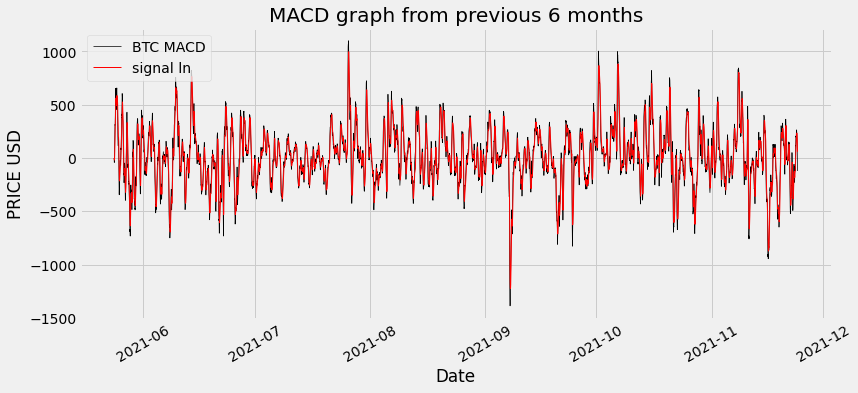

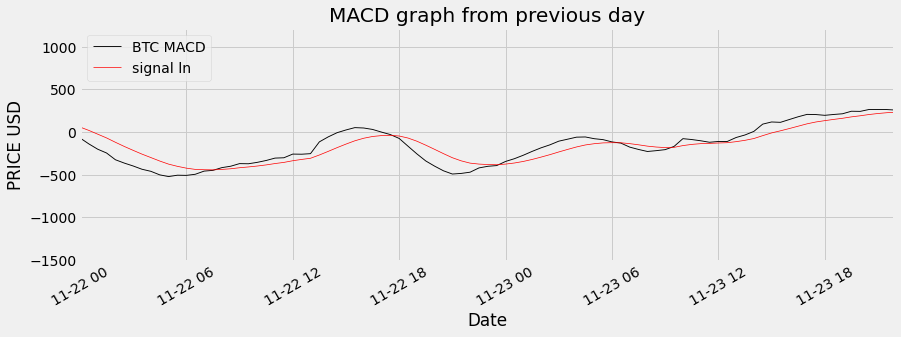

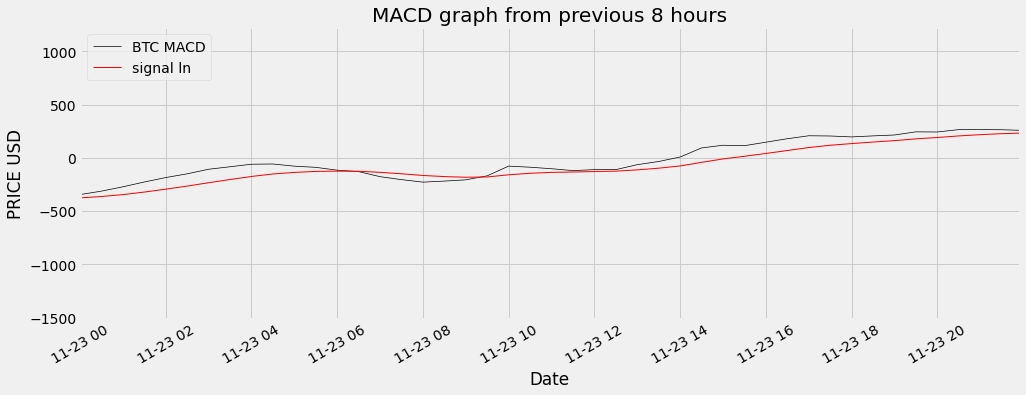

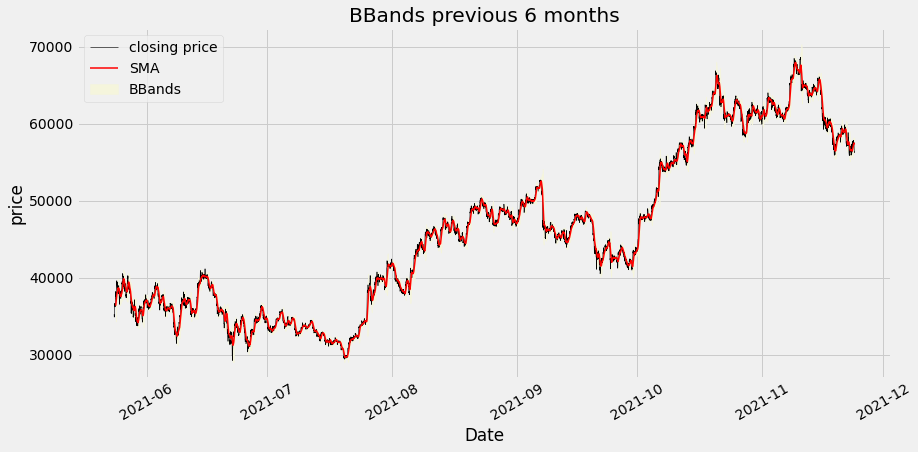

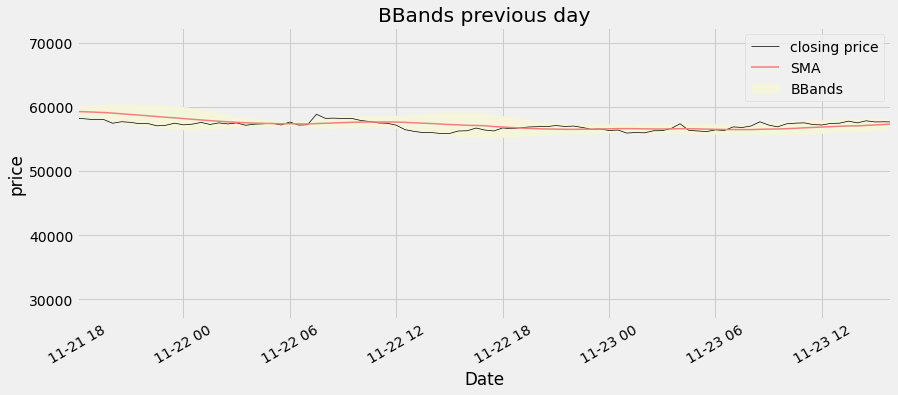

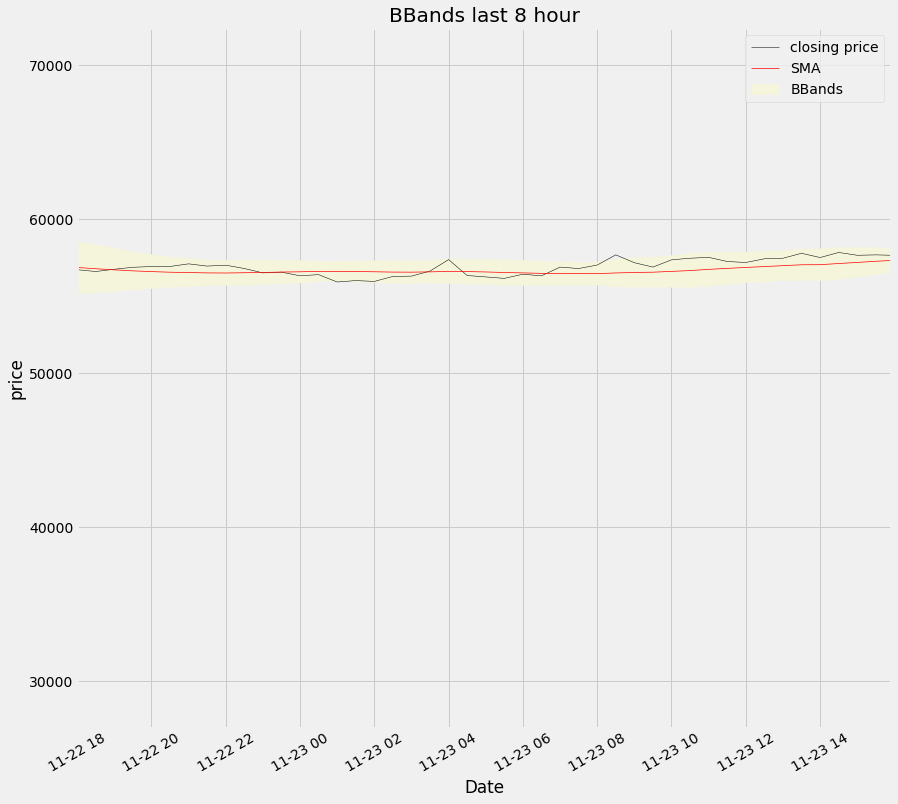

In [87]:
TI_graphs(crypto_df)

## BACKTESTING MACD

In [ ]:
# You cannot asume you will buy or sell exactly on the notification time, 
#but you can assume you will buy in the next time
Buy, Sell = [],[]
for i in range(2,len(crypto_MACD_df)):
    if crypto_MACD_df.MACD_line.iloc[i] > crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]< crypto_MACD_df.Sig_line.iloc[i-1]:
        Buy.append(i)
    elif crypto_MACD_df.MACD_line.iloc[i] < crypto_MACD_df.Sig_line.iloc[i] and\
    crypto_MACD_df.MACD_line.iloc[i-1]> crypto_MACD_df.Sig_line.iloc[i-1]:
        Sell.append(i)

In [ ]:
realbuy = [i+1 for i in Buy]
realsell = [i+1 for i in Sell]
                                                                             

In [ ]:
buyprice = crypto_MACD_df.Open.iloc[realbuy]
buyprice


In [ ]:
sellprice =crypto_MACD_df.Open.iloc[realsell]
sellprice

In [ ]:
# to calculate profit, exclude initial and final buying or selling condition
if sellprice.index[0]<buyprice.index[0]:
    sellprice = sellprice.drop(sellprice.index[0])
elif buyprice.index[-1]>buyprice.index[-1]:
    buyprice = buyprice.drop(buyprice.index[-1])
    

In [ ]:
profitsrel = []
for i in range(len(sellprice)):
    profitsrel.append((sellprice[i]-buyprice[i])/buyprice[i])

In [ ]:
profits_df = pd.DataFrame(profitsrel)
profits_df.describe()


# recomendation after machine L and TI

In [69]:

df1=crypto_MACD_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
df2=crypto_BBand_BuySell_Sig_df.fillna(0).sort_index(ascending=False)
recomendation_df1 = pd.concat([df1, df2], axis =1)
recomendation_df1


,MACD_Buy_Notification,MACD_Sell_Notification,BB_Buy_Notification,BB_Sell_Notification
Date_and_Time,,,,
2021-11-23 21:00:00-06:00,0,0,0,0
2021-11-23 20:30:00-06:00,0,0,0,0
2021-11-23 20:00:00-06:00,0,0,0,0
2021-11-23 19:30:00-06:00,0,0,0,1
2021-11-23 19:00:00-06:00,0,0,0,0
2021-11-23 18:30:00-06:00,0,0,0,0
2021-11-23 18:00:00-06:00,0,0,0,0
2021-11-23 17:30:00-06:00,0,0,0,0
2021-11-23 17:00:00-06:00,0,1,0,0


In [77]:
df3=crypto_ML_BBand_BuySell_Sig_df.fillna(0)
df4=crypto_MACD_ML_BuySell_Sig_df.fillna(0)
df5 = price_results_df[['actual_price','previously_predicted_price']]
recomendation_df2 = pd.concat([df4,df3,df5, similarity_price], axis =1)
recomendation_df2

,ML_MACD_Buy_Notification,ML_MACD_Sell_Notification,ML_BB_Buy_Notification,ML_BB_Sell_Notification,actual_price,previously_predicted_price,Similarity_percentage
0,0.0,0,0.0,0.0,57778.20,57200.506306,0.999847
1,0.0,1,0.0,0.0,57503.89,57259.945892,0.424222
2,0.0,0,0.0,0.0,57831.77,58893.570304,1.836016
3,0.0,0,0.0,0.0,57650.00,58251.744680,1.043790
4,0.0,0,0.0,0.0,57676.06,58284.576833,1.055060
5,0.0,0,0.0,0.0,57646.59,58202.126764,0.963694
6,0.0,0,0.0,0.0,57561.23,58234.998883,1.170526
7,0.0,0,0.0,0.0,57582.67,57917.977770,0.582307
8,0.0,0,0.0,0.0,57541.27,57757.174159,0.375216
9,0.0,0,0.0,0.0,57583.61,57538.060004,0.079102
